In [22]:
import numpy as np
import collections
from matplotlib import pyplot as plt
import scipy.optimize as optim
from scipy import stats
import cvxpy as cp
from tqdm import tqdm
import json
import os
from scipy.interpolate import CubicSpline, PchipInterpolator
import sys
import seaborn as sns
import pandas as pd
sys.path.append('..')

from src.samplers.importance_sampler import *
from src.data_utils import grid_data
from src.data_utils import plotting
from src.samplers.utils import check_feasibility_out_of_sample
from src.samplers import preprocessing as pre
from src.data_utils import synthetic as synth
from src.solvers import scenario_approx as SA
from src.solvers import utils as SU
from src.solvers import analytical_approx as AA

In [2]:
def map_names(
        results,
        new_names=["SA-ScenarioApprox", "SAIS-ScenarioApproxImportanceSampling"],
    ):
        for r in results.keys():
            if r not in ["Sigma", "mu"]:
                for l in results[r]:
                    keys = list(l.keys())
                    for i in range(len(keys)):
                        l[new_names[i]] = l.pop(keys[i])
        return results

def unpack_cost_foos(results, c, k, cost_correction_term):
    try:
        some_key = list(results.keys())[-1]
        names = list(results[some_key][k].keys())
    except KeyError:
        some_key = list(results.keys())[0]
        names = list(results[some_key][k].keys())
    fns = []
    xs = []
    for r in results.keys():
        if r not in ["Sigma", "mu"]:
            for v in results[r][k].values():
                try:
                    xs.append(v[0])
                    fns.append(np.dot(v[0], c) + cost_correction_term)
                except ValueError:
                    fns.append(np.nan)
    fns = np.array(fns).reshape(-1, len(names))
    #xs = np.array(xs).reshape(-1, len(names), A.shape[1])
    return fns, names


# Gathering data for turbo table

In [3]:
save_dir = os.path.join('..', 'saves')
def read_SA_statistics(save_dir, N={'grid30':303}, eta=0.05):
    pds = {}
    costs_dict = {}
    # csv_name = 'multistarts_N_' + str(N) + '_eta_' + str(eta) + '.csv'
    for directory in os.listdir(save_dir):
        if 'grid' in directory and '118i' not in directory and 'grid6' not in directory and 'grid118' not in directory:
            try:
                # Feasibility csvs
                csv_name = 'multistarts_N_' + str(N[directory]) + '_eta_' + str(eta) + '.csv'
                tmp = pd.read_csv(os.path.join(save_dir, directory, csv_name))    
                pds[directory] = tmp.drop(columns=['Unnamed: 0'])
                # Cost functions from DC-OPF & Average costs from SAs
                #grid_name = 'grid30'
                #save_dir = os.path.join("..", "saves", grid_name)

                # finding the largest N records
                # max_N = -1
                # for file in os.listdir(os.path.join(save_dir, directory)):
                
                #     if "N_" in file and "_eta" in file and ".json" in file:
                #         curr_N = int(file.split("N_")[-1].split("_eta_" + str(eta) + ".json")[0])
                #         if curr_N >= max_N:
                #             max_N = curr_N
                max_N = N[directory]
                json_file = "N_" + str(max_N) + "_eta_" + str(eta) + ".json"
                if not json_file in os.listdir(os.path.join(save_dir, directory)):
                    json_file = "N_" + str(max_N) + ".json"
                _, _, _, c, cost_correction_term, cost_dc_opf = grid_data.get_linear_constraints(directory, check_pp_vs_new_form=False)
                c = np.hstack((c, np.zeros(len(c))))
                # # load if necessary
                
                with open(os.path.join(save_dir, directory, json_file), 'r') as fp:
                    results = json.load(fp)
                results = map_names(results, new_names=['SA-ScenarioApprox', 'SAIS-ScenarioApproxImportanceSampling'])
                L = len(results[list(results.keys())[-1]])
                fns_L = []
                for l in range(L):
                    fns, names = unpack_cost_foos(results=results, c=c, k=0, cost_correction_term=cost_correction_term)
                    fns_L.append(fns)
                fns_mean = np.stack(fns_L).mean(axis=(0))
                fns_std = np.stack(fns_L).std(axis=(0))
                costs_dict[directory] = {}
                costs_dict[directory]['mean'] = fns_mean
                costs_dict[directory]['std'] = fns_std
                costs_dict[directory]['dc-opf'] = cost_dc_opf
            except FileNotFoundError:
                pass
            
    return pds, costs_dict


In [4]:
N_dict_005 = {'grid30': 273, 'grid57': 273, 'grid14': 453}
pds, costs_dict = read_SA_statistics(save_dir, N_dict_005, 0.05)
N_dict_001 = {'grid30': 453, 'grid57': 633, 'grid14': 633}
pds_001, costs_dict_001 = read_SA_statistics(save_dir, N_dict_001, 0.01)
names = pds_001[list(pds_001.keys())[0]]['Method'].unique()  

/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  Ai[:, j1:jN] = Ak[:, k1:kN].todense()
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:498: ComplexWarning: Casting complex values to real discards the imaginary part
  l[i1:iN] = self.lin["data"]["l"][name]
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  u[i1:iN] = self.lin["data"]["u"][name]
gen vm_pu > bus max_vm_pu for gens [2 3]. Setting bus limit for these gens.
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  Ai[:, j1:jN] = Ak[:, k1:kN].todense()
/Users/aleks/opt/a

cost from pandapower: 25016.000000022632
cost from pandapower: 5180.000000018376


gen vm_pu > bus max_vm_pu for gens [3 4]. Setting bus limit for these gens.
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  Ai[:, j1:jN] = Ak[:, k1:kN].todense()
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:498: ComplexWarning: Casting complex values to real discards the imaginary part
  l[i1:iN] = self.lin["data"]["l"][name]
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  u[i1:iN] = self.lin["data"]["u"][name]
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  Ai[:, j1:jN] = Ak[:, k1:kN].todense()
/Users/aleks/opt/a

cost from pandapower: 5668.00000002642
cost from pandapower: 25016.000000022632


gen vm_pu > bus max_vm_pu for gens [2 3]. Setting bus limit for these gens.
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  Ai[:, j1:jN] = Ak[:, k1:kN].todense()
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:498: ComplexWarning: Casting complex values to real discards the imaginary part
  l[i1:iN] = self.lin["data"]["l"][name]
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:499: ComplexWarning: Casting complex values to real discards the imaginary part
  u[i1:iN] = self.lin["data"]["u"][name]
gen vm_pu > bus max_vm_pu for gens [3 4]. Setting bus limit for these gens.
/Users/aleks/opt/anaconda3/envs/py39_scenario/lib/python3.9/site-packages/pandapower/pypower/opf_model.py:494: ComplexWarning: Casting complex values to real discards t

cost from pandapower: 5180.000000018376
cost from pandapower: 5668.00000002642


In [5]:
eta = 0.05
def get_summary_dict(pds, costs_dict, eta):
    summary_dict = {}
    for grid_name, pd_boxplot in pds.items():
        summary_dict[grid_name] = []
        for i in range(len(names)):
            pdSeries_tmp = (pd_boxplot.loc[(pd_boxplot["Method"] == names[i]) & (pd_boxplot["N"] > 2)])
            #pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = pdSeries_tmp["Prob_est - 1-eta"].apply(lambda x: 1.0 if x >= 0 else 0.0)
            c_est = pdSeries_tmp.columns[-1]
            pdSeries_tmp.loc[:, c_est] = (pdSeries_tmp[c_est] > 1-eta).values
            pdSeries_tmp = pdSeries_tmp.groupby("N").mean()
            x_plot = pdSeries_tmp.index
            y_plot = pdSeries_tmp[c_est].values
            # Extracting number of samples required by this method to reach 0.99 delta level (reliability)
            reliable_idx = np.where(y_plot >= 0.9)[0][0]
            # Here my homie
            n_samples_reliable = x_plot[reliable_idx]

            summary_dict[grid_name].append([n_samples_reliable,
                                             costs_dict[grid_name]['mean'][reliable_idx, i],
                                             costs_dict[grid_name]['std'][reliable_idx, i],
                                             costs_dict[grid_name]['dc-opf']
                                             ])
    summary_ord_dict = collections.OrderedDict(sorted(summary_dict.items(), key=lambda x: int(x[0].split('grid')[-1])))
    return summary_ord_dict
summary_dict = get_summary_dict(pds, costs_dict, 0.05)
summary_dict_001 = get_summary_dict(pds_001, costs_dict_001, 0.01)
# summary_dict = summary_dict_001

In [6]:
names

array(['SA-ScenarioApprox', 'SAIS-ScenarioApproxImportanceSampling'],
      dtype=object)

In [7]:
eta = 0.05
def get_summary_dict(pds, costs_dict, eta):
    summary_dict = {}
    for grid_name, pd_boxplot in pds.items():
        summary_dict[grid_name] = []
        for i in range(len(names)):
            pdSeries_tmp = (pd_boxplot.loc[(pd_boxplot["Method"] == names[i]) & (pd_boxplot["N"] > 2)])
            #pdSeries_tmp.loc[:, "Prob_est - 1-eta"] = pdSeries_tmp["Prob_est - 1-eta"].apply(lambda x: 1.0 if x >= 0 else 0.0)
            c_est = pdSeries_tmp.columns[-1]
            pdSeries_tmp.loc[:, c_est] = (pdSeries_tmp[c_est] > 1-eta).values
            pdSeries_tmp = pdSeries_tmp.groupby("N").mean()
            x_plot = pdSeries_tmp.index
            y_plot = pdSeries_tmp[c_est].values
            # Extracting number of samples required by this method to reach 0.99 delta level (reliability)
            reliable_idx = np.where(y_plot >= 0.95)[0][0]
            # Here my homie
            n_samples_reliable = x_plot[reliable_idx]

            summary_dict[grid_name].append([n_samples_reliable,
                                             costs_dict[grid_name]['mean'][reliable_idx, i],
                                             costs_dict[grid_name]['std'][reliable_idx, i],
                                             costs_dict[grid_name]['dc-opf']
                                             ])
    summary_ord_dict = collections.OrderedDict(sorted(summary_dict.items(), key=lambda x: int(x[0].split('grid')[-1])))
    return summary_ord_dict
summary_dict = get_summary_dict(pds, costs_dict, 0.05)
summary_dict_001 = get_summary_dict(pds_001, costs_dict_001, 0.01)
# summary_dict = summary_dict_001

# Compile the table

In [8]:
table = pd.DataFrame(columns=['Case', r'$\eta$', 'SA No', 'SA Cost', 'IS-SA No', 'IS-SA Cost', 'DC-OPF Cost'])
table
for i, key in enumerate(summary_dict.keys()):
    curr_grid = summary_dict[key]
    SA_res = curr_grid[0]
    ISSA_res = curr_grid[1]
    get_cost_str = lambda x, y: "{:.1e}".format(x) + r'$\pm$' + "{:.1e}".format(y)
    row = [key, 0.05, int(SA_res[0]), get_cost_str(SA_res[1], SA_res[2]),
     int(ISSA_res[0]), get_cost_str(ISSA_res[1], ISSA_res[2]), "{:.1e}".format(SA_res[-1])]
    table.loc[i] = row
for j, key in enumerate(summary_dict_001.keys()):
    curr_grid = summary_dict_001[key]
    SA_res = curr_grid[0]
    ISSA_res = curr_grid[1]
    get_cost_str = lambda x, y: "{:.1e}".format(x) + r'$\pm$' + "{:.1e}".format(y)
    row = [key, 0.01, int(SA_res[0]), get_cost_str(SA_res[1], SA_res[2]),
     int(ISSA_res[0]), get_cost_str(ISSA_res[1], ISSA_res[2]), "{:.1e}".format(SA_res[-1])]
    table.loc[i + j + 1] = row


In [9]:
print(table.to_latex(escape=False, index=False))

\begin{tabular}{lrrlrll}
\toprule
  Case &  $\eta$ &  SA No &             SA Cost &  IS-SA No &          IS-SA Cost & DC-OPF Cost \\
\midrule
grid14 &    0.05 &     93 & 5.5e+03$\pm$1.2e-11 &        93 & 5.5e+03$\pm$5.5e-12 &     5.2e+03 \\
grid30 &    0.05 &     93 & 6.0e+03$\pm$2.8e-11 &        93 & 6.3e+03$\pm$1.3e-11 &     5.7e+03 \\
grid57 &    0.05 &     93 & 2.5e+04$\pm$4.4e-11 &        93 & 2.5e+04$\pm$4.4e-11 &     2.5e+04 \\
grid14 &    0.01 &    363 & 5.6e+03$\pm$1.5e-11 &        93 & 5.5e+03$\pm$1.5e-11 &     5.2e+03 \\
grid30 &    0.01 &    363 & 6.2e+03$\pm$4.5e-12 &       183 & 6.1e+03$\pm$4.5e-12 &     5.7e+03 \\
grid57 &    0.01 &    453 & 2.5e+04$\pm$4.4e-11 &       363 & 2.5e+04$\pm$4.0e-11 &     2.5e+04 \\
\bottomrule
\end{tabular}



/var/folders/x3/2q_gzsqs643dbh4q2k13s0z80000gn/T/ipykernel_2396/437013931.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(escape=False, index=False))


# Visualizing

## Individual grid plots

In [10]:
for k, p in pds.items():
    p.rename(columns = {r'$\hat{\mathbb{P}}$': r'$(\hat{\mathbb{P}}_N)_l$'}, inplace = True)
for k, p in pds_001.items():
    p.rename(columns = {r'$\hat{\mathbb{P}}$': r'$(\hat{\mathbb{P}}_N)_l$'}, inplace = True)

Saved to  grid57/figures/1_beta_N_273.png
Saved to  grid57/figures/boxplot_J_N_273.png
Saved to  grid14/figures/1_beta_N_453.png
Saved to  grid14/figures/boxplot_J_N_183.png
Saved to  grid30/figures/1_beta_N_273.png
Saved to  grid30/figures/boxplot_J_N_183.png
Saved to  grid57/figures/1_beta_N_633_eta_0.01.png
Saved to  grid57/figures/boxplot_J_N_633_eta_0.01.png
Saved to  grid14/figures/1_beta_N_633_eta_0.01.png
Saved to  grid14/figures/boxplot_J_N_633_eta_0.01.png
Saved to  grid30/figures/1_beta_N_453_eta_0.01.png
Saved to  grid30/figures/boxplot_J_N_453_eta_0.01.png


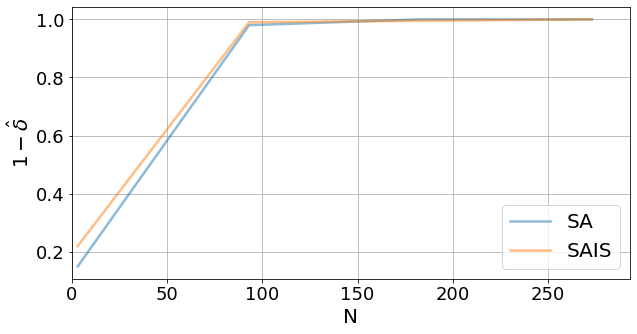

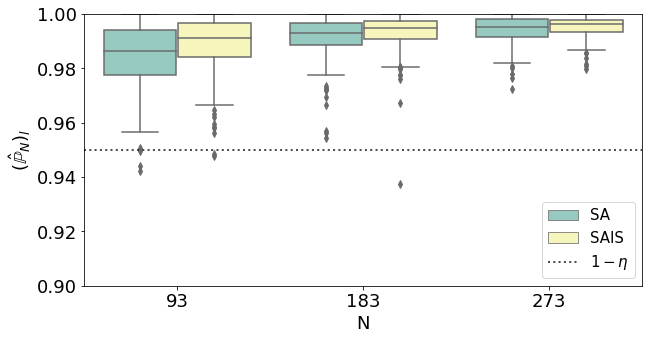

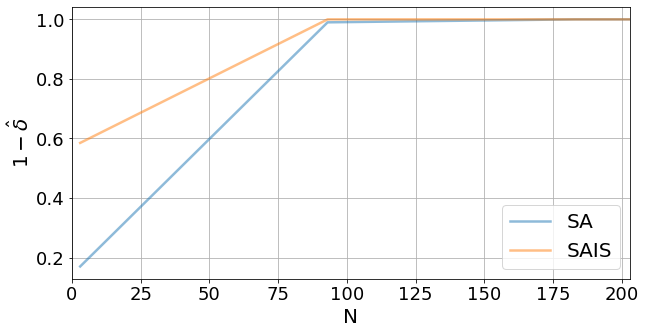

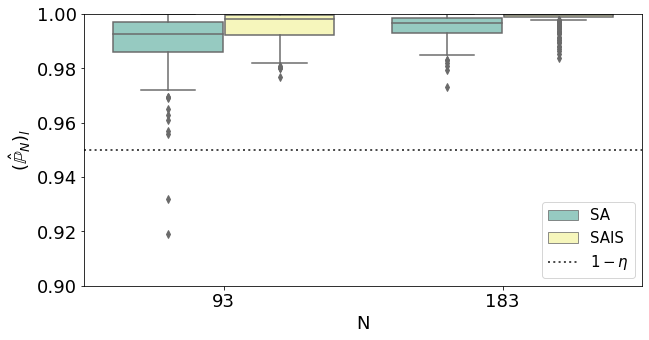

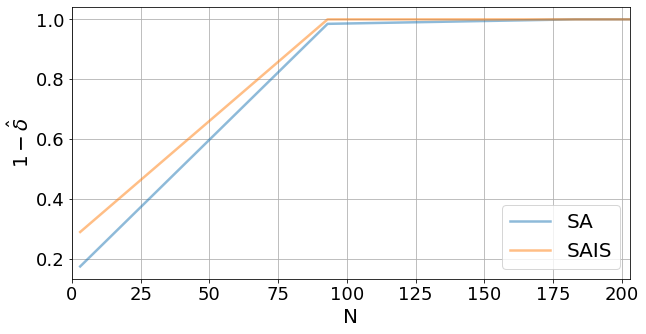

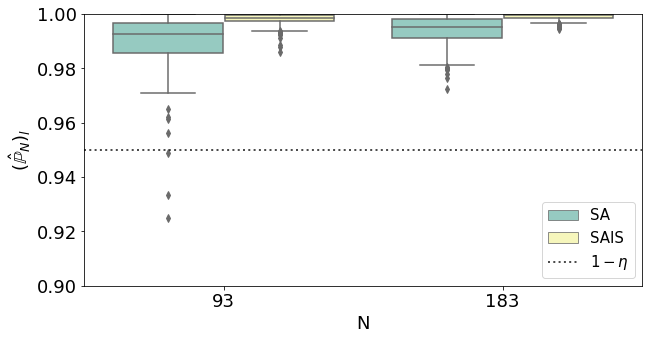

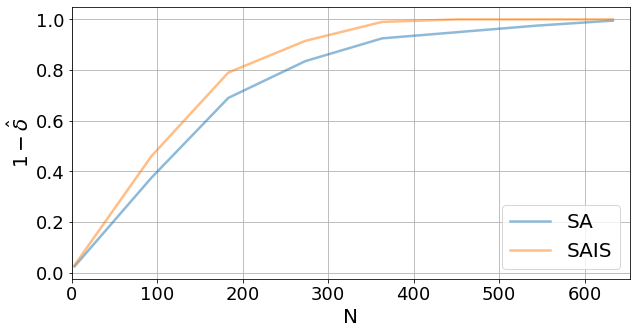

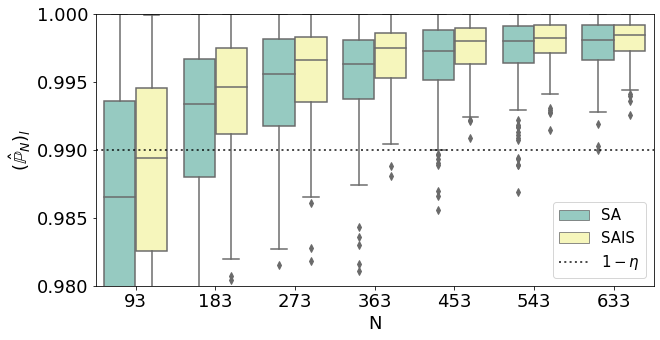

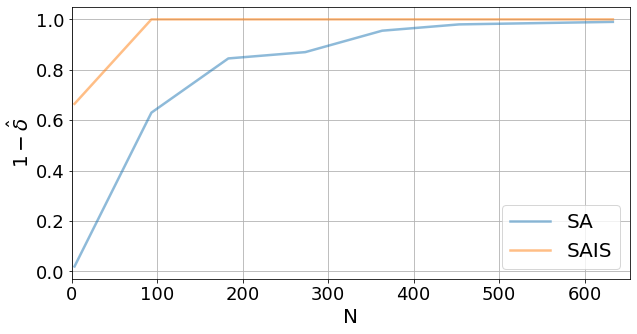

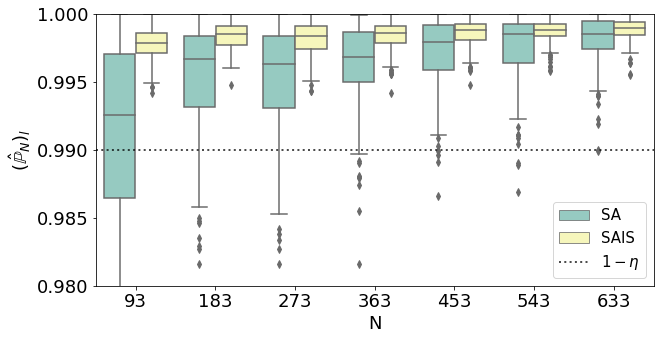

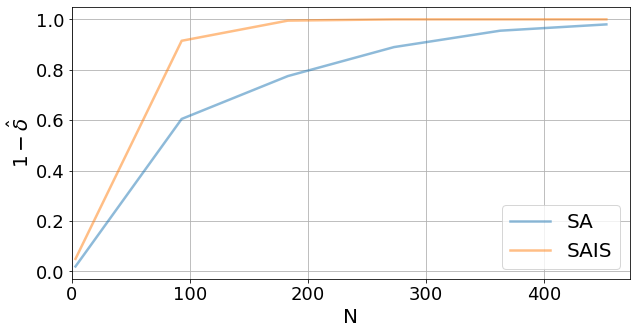

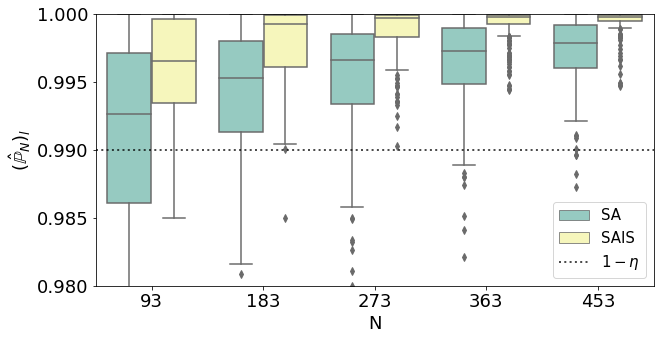

In [11]:
# plotting.plot_grids(pds, save_dir, eta=0.05, include_O = True)
# plotting.plot_grids(pds_001, save_dir, eta=0.01, include_O = True)
plotting.plot_grids(pds, None, eta=0.05, include_O = True)
plotting.plot_grids(pds_001, None, eta=0.01, include_O = True)

## Summary plots for grids

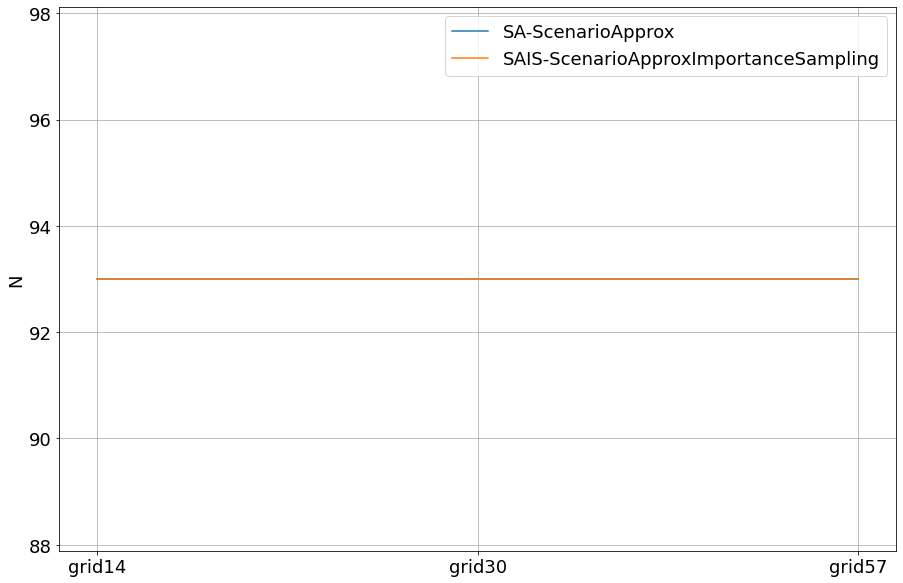

In [12]:
vals = np.array(list(summary_dict.values()))
plt.figure(figsize=(15, 10))
for i, method_name in enumerate(names):
    plt.plot(vals[:, i, 0], label=method_name)
plt.xticks(range(vals.shape[0]), labels=summary_dict.keys())
plt.legend()
#plt.yscale('log')
plt.ylabel("N")
plt.grid()
plt.savefig(os.path.join('', 'summary_plot_005.png'))

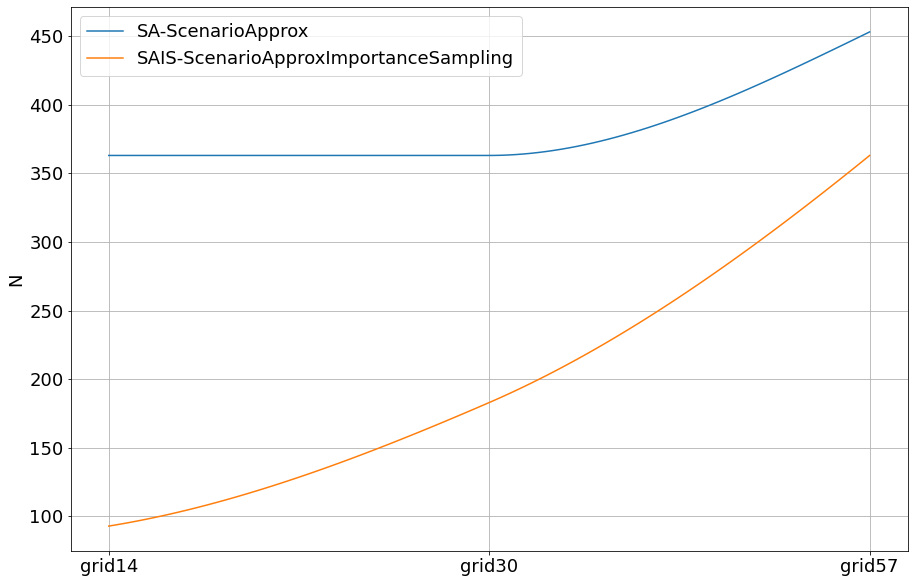

In [24]:
vals = np.array(list(summary_dict_001.values()))
plt.figure(figsize=(15, 10))

for i, method_name in enumerate(names):
    xs = np.linspace(0, vals[:, i, 0].shape[0]-1, 100)
    x = np.array(range(vals.shape[0]))
    y = vals[:, i, 0]
    cs = PchipInterpolator(x, y)
    plt.plot(xs, cs(xs), label=method_name)
    # plt.plot(vals[:, i, 0], label=method_name)
plt.xticks(range(vals.shape[0]), labels=summary_dict_001.keys())
plt.legend()
#plt.yscale('log')
plt.ylabel("N")
plt.grid()
plt.savefig(os.path.join('', 'summary_plot_001.png'))

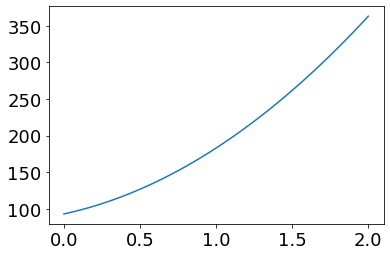

In [19]:
xs = np.linspace(0, vals[:, i, 0].shape[0]-1, 100)
x = np.array(range(vals.shape[0]))
y = vals[:, i, 0]

cs = CubicSpline(x, y)
plt.plot(xs, cs(xs), label=method_name)

In [18]:
vals[:, i, 0].shape[0]

3

In [31]:
beta = 1e-2
eta = 1e-2
d = 6
2 * (np.log(1 / beta) / eta + d + d * (np.log(1 / eta) / eta))

6459.238260383328